# Collect archived Airnow Data

Use the API to download Airnow PM$_{2.5}$ data from Sonoma County stations Sebastopol. Post process in various ways (24 h average, max, daytime max, nighttime max, convert to AQI).

## Load python packages

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from pathlib import Path # System agnostic paths

import requests # for url requests
import json # for json reading/writing
import time # for epoch timestamp
import csv # for writing csv files

## Setup website query with keys

In [2]:
#Sign up for your own email and password key for access to AirNow measurements
#https://aqs.epa.gov/aqsweb/documents/data_api.html#signup
    
#Site information we used:
#Sebastopol, 103 Morris Street, site 060970004
#param=88101
#site=0004

In [3]:
# Set up definitons for filename creation
species='PM2.5' #'PM10' or 'PM2.5'
sitename = 'Sebastopol'
yearofinterest = '2020'

In [4]:
url = 'https://aqs.epa.gov/data/api/sampleData/bySite?'
    
keys = {
        'email': 'test@aqs.api', #email for access to the api
        'key': 'test', #password for access to the api
        'param': '81102', #88101 ("PM2.5 Local Conditions"), 81102 ("PM10")
        'bdate': '20200601', #begin date (modify as needed, YYYYMMDD)
        'edate': '20200610', #end date (modify as needed, YYYYMMDD)
        'state': '06', #California
        'county': '097', #Sonoma County
        'site': '0001', #see above code cell
        }


query_AirNow = requests.get(url, keys)

## Use json reader to convert and pandas to format into array

In [5]:
response_list = query_AirNow.json()
# Uncomment below to see the result of the website query
# response_list

In [6]:
data = pd.DataFrame(response_list.get('Data'))
# Uncomment below to data formatted into an array
#data

## Query the column headers to determine what to extract and keep

In [7]:
data.columns

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'date_local',
       'time_local', 'date_gmt', 'time_gmt', 'sample_measurement',
       'units_of_measure', 'units_of_measure_code', 'sample_duration',
       'sample_duration_code', 'sample_frequency', 'detection_limit',
       'uncertainty', 'qualifier', 'method_type', 'method', 'method_code',
       'state', 'county', 'date_of_last_change', 'cbsa_code'],
      dtype='object')

## Extract data separately to make sure formatting is correct.

In [8]:
# Use pandas to convert to datetime format
extracted_date = pd.to_datetime(data['date_gmt'] + ' ' +data['time_gmt'], utc=True)
# PM2.5 should be a float
extracted_pm25 = pd.DataFrame(data[['site_number','sample_measurement','latitude','longitude']])
extracted_pm25.rename(columns = {'site_number':'id', 'sample_measurement':species,'latitude':'lat','longitude':'lon'}, inplace = True)
extracted_pm25.index = extracted_date
extracted_pm25.index.name = 'Date (UTC)'
# Uncomment below to check
#extracted_pm25

In [9]:
# Write downloaded data into a csv file
csv_name = 'AirNow_hourly_{}_{}_{}.csv'.format(species,sitename,yearofinterest)
extracted_pm25.to_csv(csv_name, na_rep='NAN', date_format='%Y%m%d %H:%M', index=True)

### Process daily values and AQI.

In [10]:
# convert to local time
extracted_pm25.index = extracted_pm25.index.tz_convert('Etc/GMT+8')
extracted_pm25.index.name = 'Date (US/Pacific Standard Time)'
extracted_pm25 = extracted_pm25.astype(float, errors = 'raise')

In [11]:
### Daily processing
# 24 h average
day_avg = extracted_pm25.resample('D').mean()
# 24 h max
day_max = extracted_pm25.resample('D').apply(lambda x : max(x, key = abs))

# Need 22 hours (>90%) to get a daily average or max
daily_count = extracted_pm25.resample('D').count()
subset_24h_avg = day_avg.where(daily_count >= 22)
subset_24h_max = day_max.where(daily_count >= 22)

subset_24h_avg_round = subset_24h_avg.round(decimals=4)
subset_24h_max_round = subset_24h_max.round(decimals=4)

#print(subset_day_avg_round, subset_day_max_round)

In [12]:
### Day/Night Processing
# 12 hr max, 8 to 8
diurnal_max = extracted_pm25.resample('12H', loffset='8H').apply(lambda x : max(x, key = abs))

# Need 11 hours (>90%) to get a daily average or max
diurnal_count = extracted_pm25.resample('12H', loffset='8H').count()
subset_diurnal_max = diurnal_max.where(diurnal_count >= 11)
subset_diurnal_max_round = subset_diurnal_max.round(decimals=4)

daytime_max = subset_diurnal_max_round[1::2]
nighttime_max = subset_diurnal_max_round[::2]

#subset_diurnal_max_round

<ipython-input-12-31e65a4471eb>:3: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  diurnal_max = extracted_pm25.resample('12H', loffset='8H').apply(lambda x : max(x, key = abs))
<ipython-input-12-31e65a4471eb>:6: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  diurnal_count = extracted_pm25.resample('12H', loffset='8H').count()


## Write to csv

In [13]:
subset_24h_avg_round.to_csv('AirNow_24havg_{}_{}.csv'.format(sitename,yearofinterest),na_rep='NAN', date_format='%Y%m%d')
subset_24h_max_round.to_csv('AirNow_24hmax_{}_{}.csv'.format(sitename,yearofinterest),na_rep='NAN', date_format='%Y%m%d')
daytime_max.to_csv('AirNow_daytimemax_{}_{}.csv'.format(sitename,yearofinterest),na_rep='NAN', date_format='%Y%m%d')
nighttime_max.to_csv('AirNow_nighttimemax_{}_{}.csv'.format(sitename,yearofinterest),na_rep='NAN', date_format='%Y%m%d')

### Convert to AQI and write out

In [14]:
def convert_AQI(PM_data):   
    final_aqi = PM_data.copy()
    # mask changes everything that does not satisfy the condition
    # for example the first line below leaves everything where 
    # final data is greater than 12, but replaces 12 or less with 1.
    final_aqi = final_aqi.where(final_aqi>12.1 ,1)
    final_aqi = final_aqi.where((final_aqi<12.1) | (final_aqi> 35.5),2)
    final_aqi = final_aqi.where((final_aqi<35.5) | (final_aqi> 55.5),3)
    final_aqi = final_aqi.where((final_aqi<55.5) | (final_aqi> 150.5),4)
    final_aqi = final_aqi.where((final_aqi<150.5) | (final_aqi> 250),5)
    final_aqi = final_aqi.where(final_aqi<250.0,6)
    # fill in all the NaN values again
    final_aqi = final_aqi.where(PM_data.notna() , np.nan)


    return final_aqi

In [15]:
#---- dataname,        datatoconvert ----
# AirNow_24havg,       subset_24h_avg_round 
# AirNow_24hmax,       subset_24h_max_round
# AirNow_daytimemax,   daytime_max
# AirNow_nighttimemax, nighttime_max

dataname = 'AirNow_nighttimetimemax'
datatoconvert = nighttime_max

aqi_data = convert_AQI(datatoconvert['PM2.5'])
d = {'id': datatoconvert['id'], 'date': datatoconvert.index, 'aqi': aqi_data,
     'lat': datatoconvert.lat.values,
     'lon': datatoconvert.lon.values}
PM25_reformat = pd.DataFrame(data=d)

In [16]:
PM25_reformat.to_csv('AQI_{}_{}_{}.csv'.format(dataname,sitename,yearofinterest),na_rep='NAN', date_format='%m/%d/%Y')

## Plot for consistency check

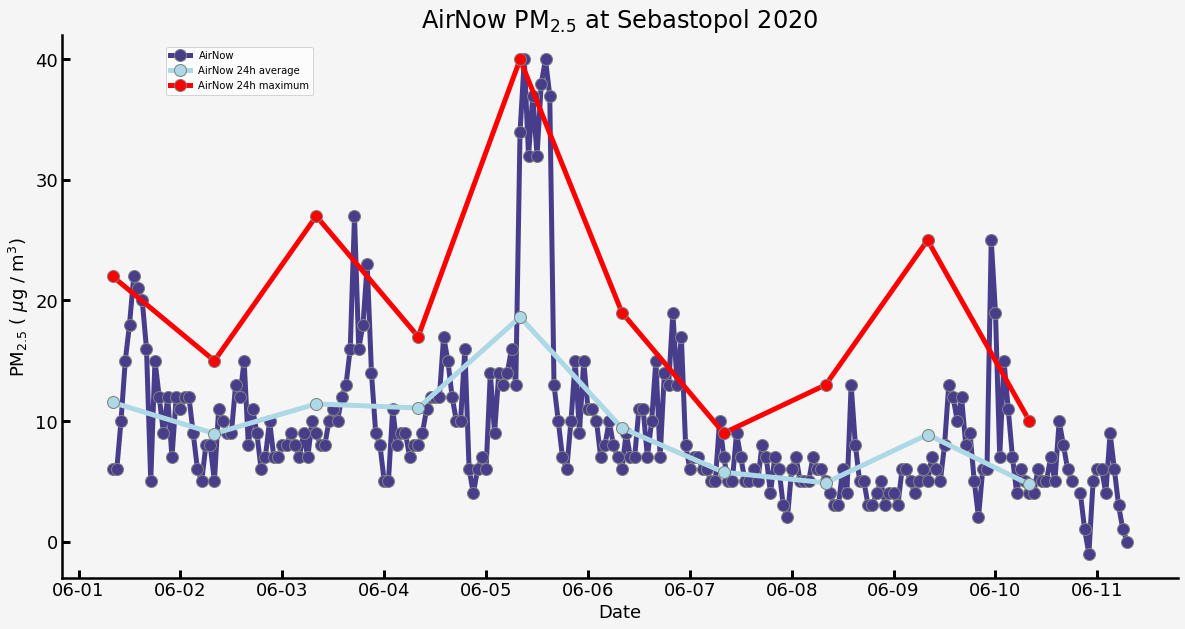

In [17]:
plt.figure(figsize=(20,10),facecolor='whitesmoke')
ax = plt.axes(facecolor='whitesmoke')

plt.plot(extracted_date, extracted_pm25['PM2.5'], '-o', label='AirNow',
         color='darkslateblue',
         markersize=12, linewidth=5,
         markerfacecolor='darkslateblue',
         markeredgecolor='grey',
         markeredgewidth=1)

plt.plot(subset_24h_avg_round.index, subset_24h_avg_round['PM2.5'], '-o', label='AirNow 24h average',
         color='lightblue',
         markersize=12, linewidth=5,
         markerfacecolor='lightblue',
         markeredgecolor='grey',
         markeredgewidth=1)

plt.plot(subset_24h_max_round.index, subset_24h_max_round['PM2.5'], '-o', label='AirNow 24h maximum',
         color='red',
         markersize=12, linewidth=5,
         markerfacecolor='red',
         markeredgecolor='grey',
         markeredgewidth=1)

#resources: named colors - https://matplotlib.org/examples/color/named_colors.html
#           default markers and lines list - https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html


# axes format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# tickmarks direction
ax.tick_params(direction='in', length=8, width=3)

# adjust border
ax.spines["left"].set_linewidth(2.5)
ax.spines["bottom"].set_linewidth(2.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# titles
plt.title('AirNow PM$_{2.5}$ at '+sitename + ' ' + yearofinterest,fontsize=24)
plt.xlabel('Date',fontsize=18)
plt.ylabel('PM$_{2.5}$ ( $\mu$g / m$^3$)',fontsize=18)

# legend
plt.legend(bbox_to_anchor=(0.23, 0.88),loc='lower right')

# write to show the plot
plt.show()
#plt.savefig('AirNow_timeseries_Sonoma.png')